<a href="https://colab.research.google.com/github/cocobridge696/ML/blob/main/UV_Bitcoin_price_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import itertools
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from tqdm import tqdm_notebook as tqdm
import _pickle as pickle
plt.style.use('ggplot')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
bc=pd.read_csv('https://query1.finance.yahoo.com/v7/finance/download/BTC-USD?period1=1537574400&period2=1632268800&interval=1d&events=history&includeAdjustedClose=true')

# Convert to datetime (useful for plotting etc)
bc['Date'] = pd.to_datetime(bc.Date)
#set index as date
bc.set_index('Date',inplace=True)
bc.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-09-22,6735.049805,6814.560059,6616.799805,6721.979980,6721.979980,4.509660e+09
2018-09-23,6715.319824,6766.149902,6679.419922,6710.629883,6710.629883,4.197500e+09
2018-09-24,6704.770020,6713.560059,6580.899902,6595.410156,6595.410156,4.177310e+09
2018-09-25,6603.640137,6603.640137,6381.859863,6446.470215,6446.470215,4.726180e+09
2018-09-26,6452.790039,6585.910156,6397.890137,6495.000000,6495.000000,4.437300e+09


# Make the data stationary:
 Stationary process has the property that the mean, variance and autocorrelation structure do not change over time. Stationarity can be defined in precise mathematical terms, but for our purpose we mean a flat looking series, without trend, constant variance over time, a constant autocorrelation structure over time and no periodic fluctuations (seasonality). It improves prediction performance by removing seasonality and trends


Convert to logs for lower p value (closer to stationary) and find the difference then test for stationarity

In [3]:
bc_log=pd.DataFrame(np.log(bc['Close'])) #use closing price
bc_log_diff=bc_log.diff().dropna() #difference between successive values,drop nan values
print(bc_log.head())
print(bc_log_diff.head())

result=adfuller(bc_log_diff['Close'])
if result[1]<0.05:
  print(f'The test P-value is {result[1]} which is below the critical value')
else:
  print(f'The test P-value is {result[1]} which is above the critical value')

  


               Close
Date                
2018-09-22  8.813138
2018-09-23  8.811448
2018-09-24  8.794129
2018-09-25  8.771288
2018-09-26  8.778788
               Close
Date                
2018-09-23 -0.001690
2018-09-24 -0.017319
2018-09-25 -0.022841
2018-09-26  0.007500
2018-09-27  0.027599
The test P-value is 5.539065529808685e-28 which is below the critical value


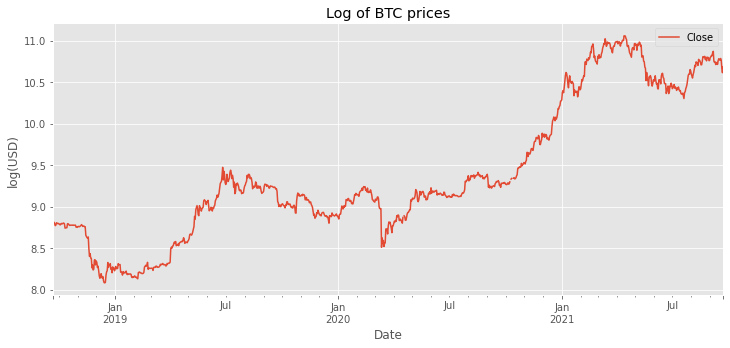

<Figure size 432x288 with 0 Axes>

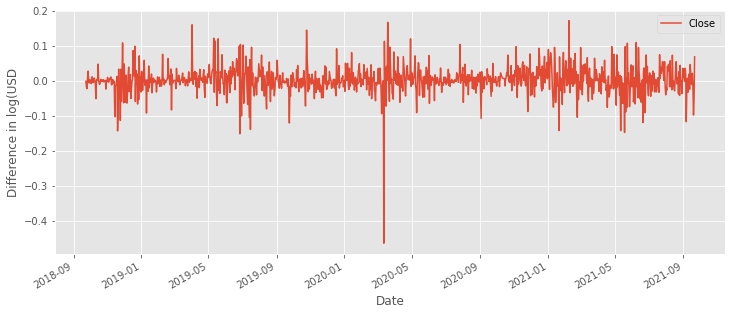

In [4]:
bc_log.plot(figsize=(12,5))
plt.title('Log of BTC prices')
plt.xlabel('Date')
plt.ylabel('log(USD)')

plt.figure()
bc_log_diff.plot(figsize=(12,5))
plt.xlabel('Date')
plt.ylabel('Difference in log(USD')
plt.show()

# SARIMA modelling

Autoregressive Integrated Moving Average, or ARIMA, is one of the most widely used forecasting methods for univariate time series data forecasting.

Although the method can handle data with a trend, it does not support time series with a seasonal component.

An extension to ARIMA that supports the direct modeling of the seasonal component of the series is called SARIMA. (https://machinelearningmastery.com/sarima-for-time-series-forecasting-in-python/)


SARIMA modelling has 2 parameters that can be chosen and optimized: order and seasonal order (https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html)

In [5]:
def opt_param(model,data,order,sorder):
  results=[]*(len(order)*len(sorder))
  for pdq in order:
    for pdqs in sorder:
      mod=model(data,order=pdq,
                seasonal_order=pdqs,
                enforce_stationarity=False,
                            enforce_invertibility=False,
                freq='D'
                            )
      result=mod.fit()
      results.append(result.aic)
  min_loc=int(np.where(results==min(results))[0][0])
  if min_loc<len(sorder):
    return min_loc,order[1],sorder[min_loc]
  else:
    return order[int(np.floor(min_loc/len(sorder)))],sorder[int(min_loc%len(sorder))],min(results)


In [6]:
# Assigning variables for p, d, q.
p = d = q = range(0,6)
d = range(2)

# Creating a list of all possible combinations of p, d, and q.
order = list(itertools.product(p, d, q))
print(len(order))

# Keeping seasonality at zeroes
sorder = [(0,0,0,0)]

72


In [7]:
print(bc_log_diff.index)
print(bc_log.index)

bc_log_diff.index=bc_log.index[8:] #dropping na values messes up index so it needs to be resetted,may affect results as index is superficial now

DatetimeIndex(['2018-09-23', '2018-09-24', '2018-09-25', '2018-09-26',
               '2018-09-27', '2018-09-28', '2018-09-29', '2018-09-30',
               '2018-10-01', '2018-10-02',
               ...
               '2021-09-13', '2021-09-14', '2021-09-15', '2021-09-16',
               '2021-09-17', '2021-09-18', '2021-09-19', '2021-09-20',
               '2021-09-21', '2021-09-22'],
              dtype='datetime64[ns]', name='Date', length=1089, freq=None)
DatetimeIndex(['2018-09-22', '2018-09-23', '2018-09-24', '2018-09-25',
               '2018-09-26', '2018-09-27', '2018-09-28', '2018-09-29',
               '2018-09-30', '2018-10-01',
               ...
               '2021-09-13', '2021-09-14', '2021-09-15', '2021-09-16',
               '2021-09-17', '2021-09-18', '2021-09-19', '2021-09-20',
               '2021-09-21', '2021-09-22'],
              dtype='datetime64[ns]', name='Date', length=1097, freq=None)


In [8]:
#find best params for stationary data
stat_opt=opt_param(SARIMAX,bc_log_diff,order,sorder) 

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

Also try using non stationary data


In [9]:
non_stat_opt=opt_param(SARIMAX,bc_log,order,sorder)

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

In [10]:
print(non_stat_opt)
print(stat_opt)

((2, 0, 1), (0, 0, 0, 0), -3941.6442599579814)
((1, 0, 0), (0, 0, 0, 0), -3929.183460102045)


# Use parameters to train SARIMAX

In [11]:
#Split train and test data
#given the first 80% can see how well the model predicts the remaining 20%
#non stat data has lower aic so will use this
trainsplit=0.8
train=bc_log['Close'][0:int(len(bc_log)*trainsplit)]
test=bc_log['Close'][int(len(bc_log)*trainsplit):]


In [12]:
mod=SARIMAX(train,order=non_stat_opt[0],
                seasonal_order=non_stat_opt[1],
                enforce_stationarity=False,
                enforce_invertibility=False,freq='D')
output=mod.fit()

In [13]:
print(output.summary())

                           Statespace Model Results                           
Dep. Variable:                  Close   No. Observations:                  877
Model:               SARIMAX(2, 0, 1)   Log Likelihood                1591.874
Date:                Tue, 05 Oct 2021   AIC                          -3175.748
Time:                        15:47:58   BIC                          -3156.651
Sample:                    09-22-2018   HQIC                         -3168.443
                         - 02-14-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3728      0.210      1.775      0.076      -0.039       0.784
ar.L2          0.6276      0.210      2.987      0.003       0.216       1.039
ma.L1          0.5636      0.222      2.543      0.0

# plot predictions


2021-02-15    10.795045
2021-02-16    10.798821
2021-02-17    10.801017
2021-02-18    10.804206
2021-02-19    10.806772
                ...    
2021-09-18    11.415732
2021-09-19    11.418698
2021-09-20    11.421664
2021-09-21    11.424631
2021-09-22    11.427600
Freq: D, Length: 220, dtype: float64


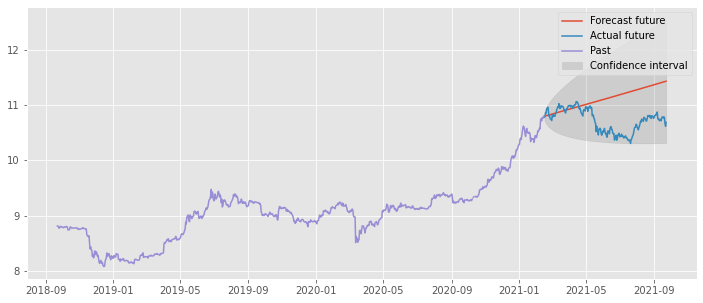

In [14]:
#get forcast
fc=output.get_forecast(len(test))
fc.index=test.index
#get confidence bounds
confid=fc.conf_int()
confid.index=test.index
l_confid=confid['lower Close']
u_confid=confid['upper Close']

print(fc.predicted_mean)
plt.figure(figsize=(12,5))
plt.plot(fc.predicted_mean,label='Forecast future')
plt.plot(test,label='Actual future')
plt.plot(train,label='Past')
#plot confidence interval
plt.fill_between(confid.index,u_confid,l_confid,color='k',alpha=0.1,label='Confidence interval')
plt.legend()
plt.show()


# LSTM model

In [15]:
#normalize data
norm_bc=(bc_log.dropna().values-bc_log.dropna().values.mean())/bc_log.dropna().values.std()
print(norm_bc)

[[-0.7043678 ]
 [-0.70640717]
 [-0.72730713]
 ...
 [ 1.53079577]
 [ 1.46866099]
 [ 1.55120396]]


In [16]:
#put in form of [all data points before for multiple chosen variables for as long back as chosen history size]

def format_data(dataset,label,start,end,history_size,target_size,single_step,step):
  data=[]
  labels=[]
  start=start+history_size
  if end is None:
    end=len(dataset)-target_size
  for i in range(start,end):
    indicies=[range(i-history_size,i,step)]
    data.append(dataset[indicies])
    if single_step:
      labels.append(label[i+target_size])
    else:
      labels.append(label[i:i+target_size])
  return np.array(data),np.array(labels)

In [17]:
#start off predicting a single day ahead using stationary data
history_size=20
data,labels=format_data(norm_bc,norm_bc,0,None,history_size,0,True,1)

trainsplit=0.9

trainsplit=int(len(data)*trainsplit)
tr_labels=labels[0:trainsplit]
train=data[0:trainsplit]

test=data[trainsplit:]
te_labels=labels[trainsplit:]

print(train.shape,tr_labels.shape,test.shape,te_labels.shape)

(965, 20, 1) (965, 1) (108, 20, 1) (108, 1)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  # This is added back by InteractiveShellApp.init_path()


In [18]:
#lstm model

import tensorflow as tf

input_shape=train.shape[-2:] #=historysize,1

lstm_model=tf.keras.models.Sequential()
lstm_model.add(tf.keras.layers.LSTM(64,input_shape=input_shape))
lstm_model.add(tf.keras.layers.Dense(100,activation='relu'))
lstm_model.add(tf.keras.layers.Dense(36,activation='relu'))
lstm_model.add(tf.keras.layers.Dense(1))
lstm_model.compile(optimizer='adam',loss='mse')

In [19]:
#DNN model
model=tf.keras.models.Sequential([
                                  tf.keras.layers.Dense(100,activation='relu',input_shape=input_shape),
                                  tf.keras.layers.Dense(36,activation='relu'),
                                  tf.keras.layers.Dense(16,activation='relu'),
                                  tf.keras.layers.Dense(1)
])
model.compile(optimizer='adam',loss='mse')

In [20]:
epochs=100



result=lstm_model.fit(x=train,y=tr_labels,epochs=epochs,validation_data=(test,te_labels))

Epoch 1/100
31/31 [==============================] - 3s 30ms/step - loss: 0.2468 - val_loss: 0.1441
Epoch 2/100
31/31 [==============================] - 0s 13ms/step - loss: 0.0167 - val_loss: 0.0113
Epoch 3/100
31/31 [==============================] - 0s 14ms/step - loss: 0.0090 - val_loss: 0.0123
Epoch 4/100
31/31 [==============================] - 0s 16ms/step - loss: 0.0071 - val_loss: 0.0077
Epoch 5/100
31/31 [==============================] - 1s 18ms/step - loss: 0.0063 - val_loss: 0.0066
Epoch 6/100
31/31 [==============================] - 1s 18ms/step - loss: 0.0061 - val_loss: 0.0069
Epoch 7/100
31/31 [==============================] - 1s 18ms/step - loss: 0.0058 - val_loss: 0.0063
Epoch 8/100
31/31 [==============================] - 1s 17ms/step - loss: 0.0054 - val_loss: 0.0070
Epoch 9/100
31/31 [==============================] - 1s 17ms/step - loss: 0.0051 - val_loss: 0.0060
Epoch 10/100
31/31 [==============================] - 1s 17ms/step - loss: 0.0052 - val_loss: 0.0049

In [21]:
result.history['val_loss'][-1]

0.002607668749988079

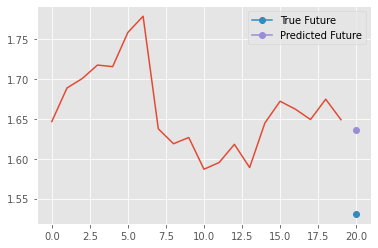

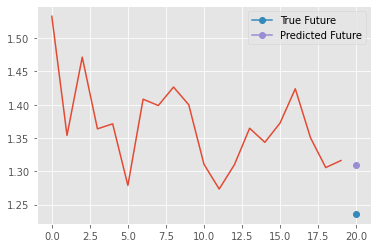

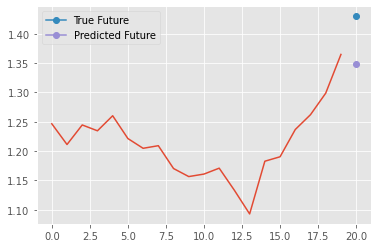

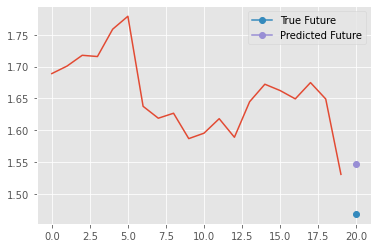

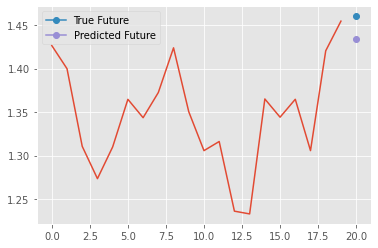

In [22]:
from random import randint
for y in range(5):
  x=randint(0,len(test)-1)
  plt.figure()
  plt.plot(test[x])
  plt.plot(history_size,te_labels[x],marker='o',label='True Future')
  plt.plot(history_size,lstm_model.predict(test[x].reshape(1,history_size,1)),marker='o',label='Predicted Future')
  plt.legend()

The lstm model achieved a MSE of 0.0026 while the basline MSE was 0.0023


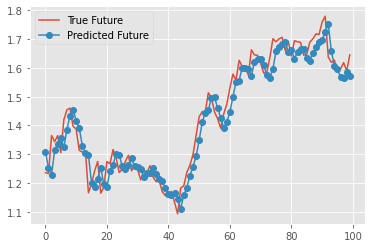

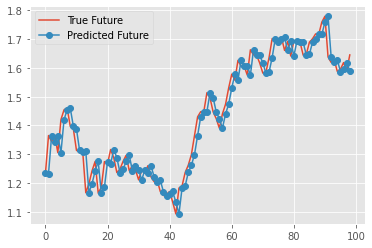

In [23]:
x=100
plt.plot(range(x),te_labels[0:x],label='True Future')
plt.plot(lstm_model.predict(test[:x]),marker='o',label='Predicted Future')
plt.legend()
plt.ylabel('')
plt.xlabel('')

lstm_mse=tf.keras.losses.MSE(te_labels.reshape(-1),lstm_model.predict(test).reshape(-1))

#compare with using just previous datapoint to predict future which can be considered a basline
plt.figure()
x=100
plt.plot(range(x-1),te_labels[1:x],label='True Future')
plt.plot(range(x-1),te_labels[:x-1],marker='o',label='Predicted Future')
plt.legend()
basline_mse=tf.keras.losses.MSE(te_labels[1:].reshape(-1),te_labels[:-1].reshape(-1))
numner=0.000505
print('The lstm model achieved a MSE of {:0.4f} while the basline MSE was {:0.4f}'.format(lstm_mse,basline_mse))

## Finding optimium history size

In [25]:
def opt_hist(norm_data,history_range,trainsplit,epochs):
  count=0
  final_loss=np.zeros([len(history_range),2])
  final_loss[:,0]=history_range
  for x in history_range:
    data,labels=format_data(norm_data,norm_data,0,None,x,0,True,1)
    train_split=int(len(data)*trainsplit)
    tr_labels=labels[0:train_split]
    train=data[0:train_split]
    test=data[train_split:]
    te_labels=labels[train_split:]
    #lstm model
    lstm_model=None
    import tensorflow as tf
    input_shape=train.shape[-2:] #=historysize,1
    lstm_model=tf.keras.models.Sequential()
    lstm_model.add(tf.keras.layers.LSTM(64,input_shape=input_shape))
    lstm_model.add(tf.keras.layers.Dense(100,activation='relu'))
    lstm_model.add(tf.keras.layers.Dense(36,activation='relu'))
    lstm_model.add(tf.keras.layers.Dense(1))
    lstm_model.compile(optimizer='adam',loss='mse')
    results=lstm_model.fit(x=train,y=tr_labels,epochs=epochs,validation_data=(test,te_labels),verbose=0)
    print(count)
    final_loss[count,1]=results.history['val_loss'][-1]
    count+=1
  return final_loss


In [26]:
history_range=range(3,30,2)
epochs=100
trainsplit=0.8
params=opt_hist(norm_bc,history_range,trainsplit,epochs)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  # This is added back by InteractiveShellApp.init_path()


0
1
2
3
4
5
6
7
8
9
10
11
12
13


In [27]:
min_loss=min(params[:,1])
opt_history=params[:,0][np.where(params[:,1]==min_loss)][0]
print('The lowest loss achieved was a MSE of {:0.4f} with a history size of {:0.4f}'.format(min_loss,opt_history))

The lowest loss achieved was a MSE of 0.0028 with a history size of 5.0000
